### MUKADDES ALTUNTAŞ, ZEYNEP DENİZ CANKUT

# CONTENT
1. [Introduction](#1)
2. [Load and Check Data](#2)
3. [Poisson Distribution](#3)
4. [Machine Learning Algorithms](#4)
5. [Results](#5)


<a id="1"> </a>
## INTRODUCTION

* Doğuş Otomotiv'de 5 farklı marka için aktif ruhsat sahipliği olan müşterilerin önümüzdeki 3 ay içinde satış dosyası açtırma olasılığı tahmin edildi. Tahmin edilmesi istenen dönem 2021 Haziran Temmuz Ağustos aylarıdır ve tahminler tekil müşteri bazında yapılmıştır.

* Bu çalışmada, en az 1 satış dosyası olan müşterilerin önümüzdeki 3 ay içinde gelme olasılıkları Poisson Dağılımı ile tahminlendi. Satış dosyası olmayan müşterileri tahminlemek içinse supervised - machine learning algoritmaları uygulanmıştır. 

* Poisson Dağılımı, her müşteri için 31 Mayıs 2021'den, müşterinin ilk geliş tarihine kadar olan sürede 3'er aylık periyotlar için müşterinin kaç satış dosyası açtırdığı bilgisi üzerinden hesaplandı. 

* Supervised - Machine Learning kısmında kullanılan müşteriye dair özellikler de 3'er aylık periyotlar için hesaplandı.

* Modellerin içeriğine dair ayrıntılı bilgilere aşağıda yer verilecektir.

<a id="2"> </a>
## LOAD AND CHECK DATA

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, minmax_scale
import datetime as dt
from datetime import datetime, date, timedelta
import scipy.stats
from scipy import stats 
from scipy.stats import poisson 
from itertools import product
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
customer = pd.read_csv('../input/dogus-datathon1/FINAL_CUSTOMER_DATATHON.csv')
cust_related = pd.read_csv('../input/dogus-datathon1/FINAL_CUSTOMER_RELATED_TABLE_FOR_DATATHON.csv')
sales = pd.read_csv('../input/dogus-datathon1/FINAL_SALES_FILE_DATATHON.csv')
new_vehicle = pd.read_csv('../input/dogus-datathon1/FINAL_SIFIR_ARAC_ALANLAR_DATATHON.csv')
vehicle = pd.read_csv('../input/dogus-datathon1/FINAL_VEHICLE_TABLE_DATATHON.csv')
service_maintenance = pd.read_csv('../input/dogus-datathon1/MASK_SERVIS_BAKIM_DATATHON_FINAL.csv')
submission = pd.read_csv('../input/dogus-datathon1/sample_submission.csv')



In [3]:
customer.drop(columns=customer.columns[0], axis=1, inplace=True)
sales.drop(columns=sales.columns[0], axis=1, inplace=True)

In [4]:
customer.info()

In [5]:
customer.describe()

In [6]:
sales.info()

In [7]:
sales.describe()

<a id="3"> </a>
## POISSON DISTRIBUTION

* Poisson Dağılımı sürekli ortamlarda (zaman, alan, hacim, … ) kesikli sonuçlar veren belli bir zaman aralığında bir yoldan geçen arabaların sayısının gözlenmesi, seyrek rastlanılan bir hastalık için belli bir zaman aralığında bu hastalığa yakalananların sayısının gözlenmesi, belli bir yılda meydana gelen doğal afetler gibi nadir rastlanan olayların modellenmesinde kullanılan bir dağılımdır. 

* Bu çalışmada her bir müşterinin önümüzdeki 3 ay içinde satış dosyası açtırma olasılığı da yukarıdaki durumlara benzerdir. Bu nedenle müşterilerden örnekler alarak bu dağılıma fit edip etmediğine baktık. Genelde örnekler dağılıma uyduğu için, tüm müşterilerde Poisson PMF(Probability Mass Function) hesaplayarak tahminleme yaptık. 

* PMF hesaplanırken şu adımlar uygulanmıştır;
    * Customer ve sales verisini birleştirdik. 
    * Veriyi 31 Mayıs 2021'den geriye doğru 3'er aylık periyotlara(quarter) böldük. Ocak 2010 ile 31 Mayıs 2021 aralığı 46 quarterdan oluşmaktadır. 

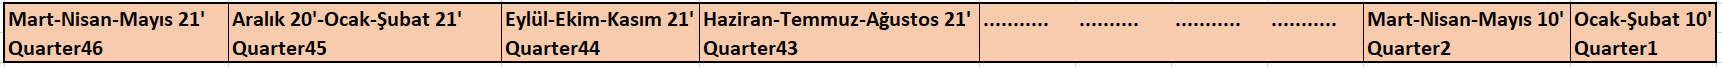 

* 
 
    * Müşteri bazında toplam farklı satış dosyası sayısını hesapladık ve her bir müşterinin ilk kez geldiği quarterı belirledik. Son quarter ile her bir müşterinin ilk kez geldiği quarter arasındaki quarter sayısını bulduk. (Böylece her bir müşterinin ne kadar zamandır müşterimiz olduğunu tespit ettik.) 
    * Her bir müşterinin satış dosyası sayısı ve kaç quarter boyunca müşteri olduğu bilgisini kullanarak, her bir müşterinin quarter bazında ortalama satış dosyası sayısını hesapladık.
    * Bu ortalamaları PMF fonksiyonunda λ değeri olarak kullandık.
    * PMF fonksiyonunda k=0 (Müşterinin önümüzdeki quarterda satış dosyası açtırmama durumu) değeri için olasılık hesapladık ve en az 1 kez satış dosyası açtırma olasılığını hesaplamak için, olasılık değerlerini 1'den çıkardık. 
    * Bu durumda satış dosyası bulunan müşterilerin her biri için ayrı ayrı olasılık değeri elde ettik.  
    

In [8]:
merge_poisson = customer.merge(sales,on='CUSTOMER_ID',how='left')
merge_poisson.shape, customer.shape, sales.shape

In [9]:
merge_poisson.info()

In [10]:
# Datetime tipine çevrildi 
merge_poisson['SF_CREATE_DATE'] = merge_poisson['SF_CREATE_DATE'].apply(pd.to_datetime)
merge_poisson['SF_CREATE_DATE'] = merge_poisson['SF_CREATE_DATE'].dt.date
merge_poisson['SF_CREATE_DATE'] = pd.to_datetime(merge_poisson['SF_CREATE_DATE'], format='%Y-%m-%d')

In [11]:
# Quarterlar hesaplandı
merge_poisson.loc[(merge_poisson['SF_CREATE_DATE'].dt.month == 12) | (merge_poisson['SF_CREATE_DATE'].dt.month == 1) | (merge_poisson['SF_CREATE_DATE'].dt.month == 2),'Quarter'] = "Q1"
merge_poisson.loc[(merge_poisson['SF_CREATE_DATE'].dt.month == 3) | (merge_poisson['SF_CREATE_DATE'].dt.month == 4) | (merge_poisson['SF_CREATE_DATE'].dt.month == 5),'Quarter'] = "Q2"
merge_poisson.loc[(merge_poisson['SF_CREATE_DATE'].dt.month == 6) | (merge_poisson['SF_CREATE_DATE'].dt.month == 7) | (merge_poisson['SF_CREATE_DATE'].dt.month == 8),'Quarter'] = "Q3"
merge_poisson.loc[(merge_poisson['SF_CREATE_DATE'].dt.month == 9) | (merge_poisson['SF_CREATE_DATE'].dt.month == 10) | (merge_poisson['SF_CREATE_DATE'].dt.month == 11),'Quarter'] = "Q4"

merge_poisson["Year"] = merge_poisson['SF_CREATE_DATE'].dt.year

# Aynı quarter a denk gelsin diye sadece aralıktaki yılı 1 arttırıyoruz.
merge_poisson.loc[(merge_poisson['SF_CREATE_DATE'].dt.month == 12) ,'Year'] = merge_poisson['SF_CREATE_DATE'].dt.year + 1
merge_poisson["QUARTER"] = merge_poisson["Quarter"]+"-"+merge_poisson["Year"].astype(str)

# En az 1 satış dosyası olan müşteriler alındı
merge_poisson = merge_poisson[merge_poisson['SF_CREATE_DATE'].notna()]


In [12]:
merge_poisson.head()

In [13]:
# Quarterlara kronolojik olarak numara verildi
quarters = merge_poisson.groupby(['Year','Quarter'])['SALESFILE_ID'].count().reset_index()
quarters['quarter_number'] = quarters.index + 1
quarters = quarters[['Year','Quarter','quarter_number']]
quarters.head()

In [14]:
# Satış-müşteri verisiyle quarter numarası birleştirildi 
merge_poisson = merge_poisson.merge(quarters,on=['Year','Quarter'],how='left')
merge_poisson.head()

In [15]:
# Her bir müşterinin ilk geldiği quarter bulundu
min_qt = merge_poisson.groupby('BASE_CUSTOMER_ID')['quarter_number'].min().reset_index()
min_qt.head()

In [16]:
# Son quarter ile her bir müşterinin ilk kez geldiği quarter arasındaki quarter sayısı bulundu
min_qt['qt_difference'] = merge_poisson['quarter_number'].max() - min_qt['quarter_number']
min_qt.head()

In [17]:
# Her bir müşterinin toplam farklı satış dosyası sayısı bulundu
sales_total = merge_poisson.groupby('BASE_CUSTOMER_ID')['SALESFILE_ID'].nunique().reset_index()
sales_total.head()

In [18]:
sales_total.rename(columns={'SALESFILE_ID':'salesfile_total'},inplace=True)

In [19]:
# Ortalama satış dosyası sayısını bulmak için iki dataframe birleştirildi
qt_avg = min_qt.merge(sales_total,on='BASE_CUSTOMER_ID',how='left')
qt_avg.head()

In [20]:
# Her bir müşteri için ortalama satış dosyası sayısı bulundu
qt_avg['avg_salesfile'] = qt_avg['salesfile_total'] / qt_avg['qt_difference']
qt_avg.head()

In [21]:
# Her bir müşterinin quarter bazlı açtırdığı dosya sayısını hesaplıyoruz.

data_poisson = pd.DataFrame(merge_poisson.groupby(['BASE_CUSTOMER_ID','QUARTER'])['SALESFILE_ID'].count()).reset_index()
data_poisson_sorted = data_poisson.sort_values(['SALESFILE_ID'],ascending=True).groupby('BASE_CUSTOMER_ID').head(100000)
data_poisson_sorted[data_poisson_sorted['BASE_CUSTOMER_ID'] == 89181]

In [22]:
# Her bir müşteri için bir quarterda ortalama kaç dosya açtırdığını hesapladık. Bu ortalama üzerinden PMF grafiği
# oluşturduk. Verinin gerçekteki dağılımı ile PMF grafiğinin fit edip etmediğini kontrol ettik. 
# Uzun süredir müşteri olan ve geliş sıklığı fazla olan kişilerde iki grafiğin fit ettiğini gözlemledik.


def draw_poisson_graph(sample_must, data_poisson_sorted):
    aa = []
    aa = data_poisson_sorted[data_poisson_sorted['BASE_CUSTOMER_ID'] == sample_must]['SALESFILE_ID']
    sample_must_avg_mean = qt_avg[qt_avg['BASE_CUSTOMER_ID'] == sample_must]['avg_salesfile'].mean()
    
    
    # Dağılımları oluşturalım
    p1 = poisson(sample_must_avg_mean)
    p4 = poisson(sample_must_avg_mean)
    
    
    n = aa.max()
    x = np.linspace(0,n,n+1)
    
    
    pmf1 = np.array([p1.pmf(i) for i in aa])
    pmf4 = np.array([p4.pmf(i) for i in x])
    
    
    
    plt.plot(aa, pmf1, 'r')
    plt.scatter(aa,pmf1,c='r')
    plt.plot(x, pmf4, 'g')
    # plt.scatter(x, pmf4,c='g')
    plt.title("Poisson PMF")
    plt.legend(["Data Distribution","Real Distribution"])
    plt.show()

In [23]:
draw_poisson_graph(89181, data_poisson_sorted)

In [24]:
draw_poisson_graph(107531, data_poisson_sorted)

In [25]:
draw_poisson_graph(139494, data_poisson_sorted)

In [26]:
draw_poisson_graph(138530, data_poisson_sorted)

In [27]:
# k=0, λ = qt_avg['avg_salesfile'] değerleri için PMF sonucu hesaplandı
pmf_results = list(scipy.stats.poisson.pmf(0, qt_avg['avg_salesfile']))

In [28]:
# Her bir müşterinin önümüzdeki quarterda gelme olasılığı hesaplandı
new_tmp = qt_avg.assign(Expected = pmf_results)
new_tmp['Expected'] = 1 - new_tmp['Expected']
new_tmp.head()

In [29]:
new_tmp = new_tmp[['BASE_CUSTOMER_ID','Expected']]
new_tmp.rename(columns={'BASE_CUSTOMER_ID':'Id'},inplace=True)

In [30]:
# En az 1 satış dosyası olan müşterilerin gelme olasılığı Poisson Dağılımı ile tahmin edildi 
df_poisson = submission[['Id']].merge(new_tmp,on='Id',how='left')
df_poisson.head()

In [31]:
# Hiç satış dosyası olmayan müşteriler supervised - machine learning algoritmaları ile modellendi.

<a id="4"> </a>
## MACHINE LEARNING ALGORITHMS

In [32]:
# Datetime tipine çevrildi
service_maintenance['CREATE_DATE'] = pd.to_datetime(service_maintenance['CREATE_DATE'], format='%Y-%m-%d')
service_maintenance['CREATE_DATE'] = service_maintenance['CREATE_DATE'].dt.date
service_maintenance['CREATE_DATE'] = pd.to_datetime(service_maintenance['CREATE_DATE'], format='%Y-%m-%d')
service_maintenance.info()

### Servis ve Bakım ile ilgili özellik olarak servis ve bakım oranı, frekansı ve toplam harcanan miktar bulundu.

In [33]:
# Toplam servis-bakım sayısı bulundu
service_maintenance_total = service_maintenance.groupby(['VEHICLE_ID'])['IS_MAINTENANCE'].count().reset_index()
service_maintenance_total.rename(columns={'IS_MAINTENANCE':'service_maintenance_total'},inplace=True)

In [34]:
# Bakım ve servis ayrı ayrı ele alındı
maintenance = service_maintenance[service_maintenance['IS_MAINTENANCE'] == 1]
service = service_maintenance[service_maintenance['IS_MAINTENANCE'] == 0]

In [35]:
# Toplam bakım sayısı bulundu
maintenance_total = maintenance.groupby(['VEHICLE_ID'])['CREATE_DATE'].count().reset_index()
maintenance_total.rename(columns={'CREATE_DATE':'maintenance_total'},inplace=True)
maintenance_total.head()

In [36]:
# Toplam servis sayısı bulundu
service_total = service.groupby(['VEHICLE_ID'])['CREATE_DATE'].count().reset_index()
service_total.rename(columns={'CREATE_DATE':'service_total'},inplace=True)
service_total.head()

In [37]:
# Toplam servis-bakım bilgisi ile toplam bakım ve toplam servis sayısı birleştirildi
service_maintenance_total = service_maintenance_total.merge(maintenance_total,on='VEHICLE_ID',how='left')
service_maintenance_total = service_maintenance_total.merge(service_total,on='VEHICLE_ID',how='left')

In [38]:
# Toplam servis-bakımın yüzde kaçı bakım yüzde kaçı servis bulundu
service_maintenance_total['maintenance_rate'] = service_maintenance_total['maintenance_total'] / service_maintenance_total['service_maintenance_total'] 
service_maintenance_total['service_rate'] = service_maintenance_total['service_total'] / service_maintenance_total['service_maintenance_total'] 
service_maintenance_total.head()

In [39]:
service_maintenance_total.fillna(0,inplace=True) 
service_maintenance_total.head()

In [40]:
# Quarterlar hesaplandı
service_maintenance.loc[(service_maintenance['CREATE_DATE'].dt.month == 12) | (service_maintenance['CREATE_DATE'].dt.month == 1) | (service_maintenance['CREATE_DATE'].dt.month == 2),'Quarter'] = "Q1"
service_maintenance.loc[(service_maintenance['CREATE_DATE'].dt.month == 3) | (service_maintenance['CREATE_DATE'].dt.month == 4) | (service_maintenance['CREATE_DATE'].dt.month == 5),'Quarter'] = "Q2"
service_maintenance.loc[(service_maintenance['CREATE_DATE'].dt.month == 6) | (service_maintenance['CREATE_DATE'].dt.month == 7) | (service_maintenance['CREATE_DATE'].dt.month == 8),'Quarter'] = "Q3"
service_maintenance.loc[(service_maintenance['CREATE_DATE'].dt.month == 9) | (service_maintenance['CREATE_DATE'].dt.month == 10) | (service_maintenance['CREATE_DATE'].dt.month == 11),'Quarter'] = "Q4"

service_maintenance["Year"] = service_maintenance['CREATE_DATE'].dt.year

# Aynı quarter a denk gelsin diye sadece aralıktaki yılı 1 arttırıyoruz.
service_maintenance.loc[(service_maintenance['CREATE_DATE'].dt.month == 12) ,'Year'] = service_maintenance['CREATE_DATE'].dt.year + 1

service_maintenance["QUARTER"] = service_maintenance["Quarter"]+"-"+service_maintenance["Year"].astype(str)

In [41]:
# Servis ve bakım verileri ayrı ayrı ele alındı
service_maintenance_ = service_maintenance.sort_values(['VEHICLE_ID', 'CREATE_DATE'])
maintenance_ = service_maintenance_[service_maintenance_['IS_MAINTENANCE'] == 1]
service_ = service_maintenance_[service_maintenance_['IS_MAINTENANCE'] == 0]

In [42]:
# Her bir aracın her bir quarterdaki bakımları arasındaki gün sayısı hesaplandı
maintenance_['maintenance_freq_qt'] = maintenance_.groupby(['VEHICLE_ID','QUARTER'])['CREATE_DATE'].diff().dt.days
maintenance_.head()

In [43]:
# Bir quarter içerisinde sadece 1 kere bakım yapılmış araçlar için maksimum frekanstan daha yüksek bir sayı verildi
# Örneğin bir quarterın başında ve sonunda bakım yapıldıysa bu durumda frekans ~90 gün olur 
maintenance_.loc[maintenance_.maintenance_freq_qt.isnull(),'maintenance_freq_qt'] = 150

In [44]:
# Araca bakım yapılmadığı quarterlardaki frekansa 1 kere geldiği quarterdaki frekanstan daha yüksek
# bir sayı vereceğiz. Aracın bakım yapılmadığı quarterları bulmak için product matrix ten yararlandık.

# product matrix = number of unique vehicles X number of unique quarters

quarter_unique = service_maintenance.drop_duplicates(subset='QUARTER',keep='first')
vehicle_unique = service_maintenance.drop_duplicates(subset='VEHICLE_ID',keep='first')


prod_matrix = product(vehicle_unique['VEHICLE_ID'].unique(), quarter_unique['QUARTER'].unique())
prod_matrix = pd.DataFrame(list(prod_matrix),columns=['VEHICLE_ID','QUARTER'])
prod_matrix.shape

In [45]:
# Her bir aracın her bir quarterdaki bakım frekansı hesaplandı
maintenance_mean = maintenance_.groupby(['VEHICLE_ID','QUARTER'])['maintenance_freq_qt'].mean().reset_index()

In [46]:
prod_matrix = prod_matrix.merge(maintenance_mean[['VEHICLE_ID','QUARTER','maintenance_freq_qt']],on=['VEHICLE_ID','QUARTER'],how='left')

In [47]:
# Araca bakım yapılmadığı quarterlardaki frekansa, 1 kere yapıldığı quarterdaki frekanstan(150) daha yüksek
# bir sayı olan 200 ü verdik

prod_matrix.loc[prod_matrix.maintenance_freq_qt.isnull(),'maintenance_freq_qt'] = 200

In [48]:
# Her bir aracın her bir quarterdaki servisleri arasındaki gün sayısı hesaplandı
service_['service_freq_qt'] = service_.groupby(['VEHICLE_ID','QUARTER'])['CREATE_DATE'].diff().dt.days
service_.head()

In [49]:
# Bir quarter içerisinde sadece 1 kere servise gelmiş araçlar için maksimum frekanstan daha yüksek bir sayı verildi
# Örneğin bir quarterın başında ve sonunda servise geldiyse bu durumda frekans ~90 gün olur 
service_.loc[service_.service_freq_qt.isnull(),'service_freq_qt'] = 150

In [50]:
# Her bir aracın her bir quarterdaki servis frekansı hesaplandı
service_mean = service_.groupby(['VEHICLE_ID','QUARTER'])['service_freq_qt'].mean().reset_index()

In [51]:
prod_matrix = prod_matrix.merge(service_mean[['VEHICLE_ID','QUARTER','service_freq_qt']],on=['VEHICLE_ID','QUARTER'],how='left')
prod_matrix.head()

In [52]:
# Aracın servise gelmediği quarterlardaki frekansa, 1 kere geldiği quarterdaki frekanstan(150) daha yüksek
# bir sayı olan 200 ü verdik

prod_matrix.loc[prod_matrix.service_freq_qt.isnull(),'service_freq_qt'] = 200

In [53]:
# Bakıma harcanan toplam miktar bulundu
maintenance_amount = maintenance_.groupby(['VEHICLE_ID','QUARTER'])['TOTAL_AMOUNT_TL'].sum().reset_index()
maintenance_amount.rename(columns={'TOTAL_AMOUNT_TL':'maintenance_amount'},inplace=True)

In [54]:
# Servise harcanan toplam miktar bulundu
service_amount = service_.groupby(['VEHICLE_ID','QUARTER'])['TOTAL_AMOUNT_TL'].sum().reset_index()
service_amount.rename(columns={'TOTAL_AMOUNT_TL':'service_amount'},inplace=True)

In [55]:
prod_matrix = prod_matrix.merge(maintenance_amount,on=['VEHICLE_ID','QUARTER'],how='left')
prod_matrix = prod_matrix.merge(service_amount,on=['VEHICLE_ID','QUARTER'],how='left')
prod_matrix.head()

In [56]:
# Bakım veya servis yapılmayan quarterlar için harcanan miktar 0 ile dolduruldu
prod_matrix.fillna(0,inplace=True)

### Müşteriler ile ilgili özelliklerden Yaş, Cinsiyet ve Medeni Durum bilgilerini kullandık. Müşteriler ve araçlarla ilgili özellikleri birleştirdik.

In [57]:
# Müşterileri ve ilişkili oldukları araçları elde ettik
cust_related_unique = cust_related.drop_duplicates(subset=['BASE_CUSTOMER_ID','VEHICLE_ID'],keep='last')
customer_vehicle = prod_matrix.merge(cust_related_unique[['BASE_CUSTOMER_ID','VEHICLE_ID']],on='VEHICLE_ID',how='left')
customer_vehicle.head()

In [58]:
# Müşteri yaşı hesaplandı
customer['age'] = datetime.now().year - customer['BIRTH_DATE']

In [59]:
# Müşterilerin eksik bilgileri dolduruldu  
customer['age']=customer['age'].groupby(customer['BASE_CUSTOMER_ID']).fillna(method='ffill')
customer['age']=customer['age'].groupby(customer['BASE_CUSTOMER_ID']).fillna(method='bfill')
customer['GENDER_ID']=customer['GENDER_ID'].groupby(customer['BASE_CUSTOMER_ID']).fillna(method='ffill')
customer['GENDER_ID']=customer['GENDER_ID'].groupby(customer['BASE_CUSTOMER_ID']).fillna(method='bfill')
customer['MARITAL_STATUS_ID']=customer['MARITAL_STATUS_ID'].groupby(customer['BASE_CUSTOMER_ID']).fillna(method='ffill')
customer['MARITAL_STATUS_ID']=customer['MARITAL_STATUS_ID'].groupby(customer['BASE_CUSTOMER_ID']).fillna(method='bfill')

customer.loc[customer['age'].isna(),'age'] = customer['age'].median()
customer.loc[customer['GENDER_ID']==0,'GENDER_ID'] = customer['GENDER_ID'].median()
customer.loc[customer['MARITAL_STATUS_ID']==0,'MARITAL_STATUS_ID'] = customer['MARITAL_STATUS_ID'].median()
customer.GENDER_ID.unique(),customer.MARITAL_STATUS_ID.unique()

In [60]:
# Müşteri bilgilerini araç bilgileriyle birleştirdik
customer_unique = customer.drop_duplicates(subset='BASE_CUSTOMER_ID',keep='first')
customer_vehicle = customer_vehicle.merge(customer_unique,on='BASE_CUSTOMER_ID',how='left')
customer_vehicle.head()

### Makine öğrenmesi modeli kurulurken son quarterda satış dosyası olan müşterilere 1 flag i verildi. Diğer tüm müşterilere 0 flag i verildi. Müşteri ve araç ile ilgili özellikler son quarter hariç tutularak alındı. Train bu özelliklere göre yapıldı. Test kısmında ise son quarter dahil edilerek, ilk quarter çıkarılarak özellikler hesaplandı. 


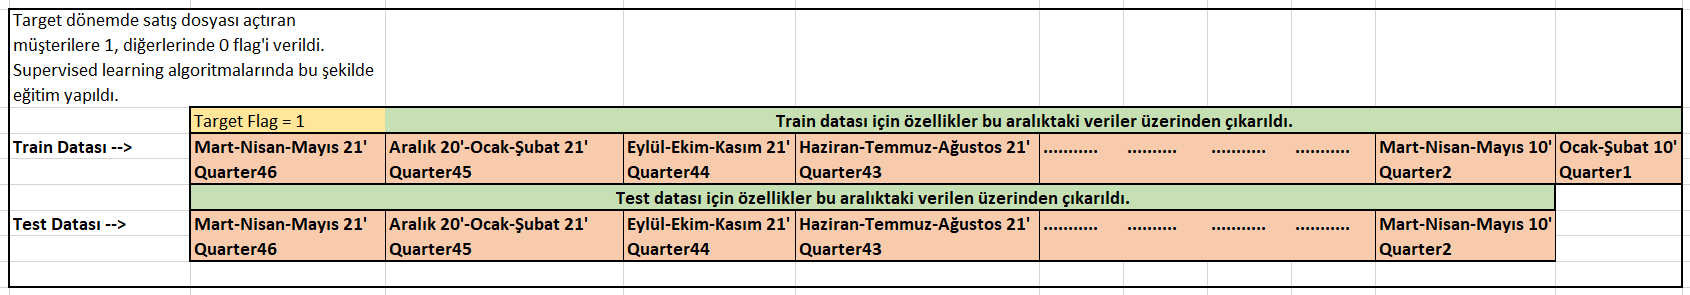

In [61]:
merged = customer.merge(sales,on='CUSTOMER_ID',how='left')
merged.head()

In [62]:
merged['SF_CREATE_DATE'] = merged['SF_CREATE_DATE'].apply(pd.to_datetime)
merged['SF_CREATE_DATE'] = merged['SF_CREATE_DATE'].dt.date
merged['SF_CREATE_DATE'] = merged['SF_CREATE_DATE'].apply(pd.to_datetime)

In [63]:
merged.loc[(merged['SF_CREATE_DATE'].dt.month == 12) | (merged['SF_CREATE_DATE'].dt.month == 1) | (merged['SF_CREATE_DATE'].dt.month == 2),'Quarter'] = "Q1"
merged.loc[(merged['SF_CREATE_DATE'].dt.month == 3) | (merged['SF_CREATE_DATE'].dt.month == 4) | (merged['SF_CREATE_DATE'].dt.month == 5),'Quarter'] = "Q2"
merged.loc[(merged['SF_CREATE_DATE'].dt.month == 6) | (merged['SF_CREATE_DATE'].dt.month == 7) | (merged['SF_CREATE_DATE'].dt.month == 8),'Quarter'] = "Q3"
merged.loc[(merged['SF_CREATE_DATE'].dt.month == 9) | (merged['SF_CREATE_DATE'].dt.month == 10) | (merged['SF_CREATE_DATE'].dt.month == 11),'Quarter'] = "Q4"

merged["Year"] = merged['SF_CREATE_DATE'].dt.year

#Aynı quarter a denk gelsin diye sadece aralıktaki yılı 1 arttırıyoruz.
merged.loc[(merged['SF_CREATE_DATE'].dt.month == 12) ,'Year'] = merged['SF_CREATE_DATE'].dt.year + 1

merged["QUARTER"] = merged["Quarter"]+"-"+merged["Year"].astype(str)
merged.head()

In [64]:
# Son quarterda dosyası olan müşterilerin Target ı 1 verildi, diğer müşterilere 0 verildi.
merged.loc[merged['QUARTER'] == 'Q2-2021.0','Target'] = 1
merged.loc[merged['QUARTER'] != 'Q2-2021.0','Target'] = 0

In [65]:
merge_target = merged.groupby(['BASE_CUSTOMER_ID','QUARTER'])['Target'].max().reset_index()
merge_target.Target.value_counts()

In [66]:
merge_target = merge_target.groupby(['BASE_CUSTOMER_ID'])['Target'].max().reset_index()
merge_target.head()

In [67]:
# Train verisinde kullanmak için son quarter hariç bırakılarak özellikler elde edildi
customer_vehicle_except_last_qt = customer_vehicle[customer_vehicle['QUARTER'] != 'Q2-2021.0']

In [68]:
# Müşteri bazlı tek bir satır elde etmek için ortalamalar alındı
customer_vehicle_inf = customer_vehicle_except_last_qt.groupby('BASE_CUSTOMER_ID')['maintenance_freq_qt'].mean().reset_index()
customer_vehicle_inf.rename(columns={'maintenance_freq_qt':'maintenance_freq_avg'},inplace=True)
customer_vehicle_inf2 = customer_vehicle_except_last_qt.groupby('BASE_CUSTOMER_ID')['service_freq_qt'].mean().reset_index()
customer_vehicle_inf2.rename(columns={'service_freq_qt':'service_freq_avg'},inplace=True)
customer_vehicle_inf3 = customer_vehicle_except_last_qt.groupby('BASE_CUSTOMER_ID')['maintenance_amount'].sum().reset_index()
customer_vehicle_inf4 = customer_vehicle_except_last_qt.groupby('BASE_CUSTOMER_ID')['service_amount'].sum().reset_index()

In [69]:
customer_vehicle_info = pd.concat([customer_vehicle_inf[['BASE_CUSTOMER_ID','maintenance_freq_avg']],customer_vehicle_inf2['service_freq_avg'],customer_vehicle_inf3['maintenance_amount'],customer_vehicle_inf4['service_amount']],axis=1)

In [70]:
# Kategorik özellikler için one hot encoding yapıldı ve müşteri bilgileri çıkarıldı
base_cust_unique = customer_vehicle_except_last_qt.drop_duplicates(subset='BASE_CUSTOMER_ID',keep='first')
base_cust_unique = base_cust_unique[['BASE_CUSTOMER_ID','GENDER_ID','MARITAL_STATUS_ID', 'age']]

base_cust_unique = pd.get_dummies(base_cust_unique, prefix="GENDER_ID", columns=["GENDER_ID"])
base_cust_unique = pd.get_dummies(base_cust_unique, prefix="MARITAL_STATUS_ID", columns=["MARITAL_STATUS_ID"])
base_cust_unique.head()

In [71]:
customer_info = base_cust_unique.merge(customer_vehicle_info,on='BASE_CUSTOMER_ID',how='left')
customer_info.head()

In [72]:
customer_info = customer_info.merge(merge_target,on='BASE_CUSTOMER_ID',how='left')
customer_info.loc[customer_info.Target.isnull(),'Target'] = 0

In [73]:
customer_info = customer_info.merge(df_poisson,left_on='BASE_CUSTOMER_ID',right_on='Id',how='left')
customer_info.head()

In [74]:
customer_info.loc[customer_info.Expected.isnull(),'Expected'] = 0
customer_info.head()

In [75]:
X_train = customer_info.drop(['BASE_CUSTOMER_ID','Target','Id'],axis=1)
X_train.head()

In [76]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [77]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=['Yas', 'GENDER_ID_100', 'GENDER_ID_101', 'MARITAL_STATUS_ID_101',
       'MARITAL_STATUS_ID_102', 'Bakim_Frekans_Avg', 'Servis_Frekans_Avg',
       'Bakim_Toplam_Miktar', 'Servis_Toplam_Miktar', 'Expected'])

In [78]:
X_train_scaled.head()

In [79]:
y_train = customer_info.Target

In [80]:
# Çıkarılan özelliklerin birbirleriyle ve targetla ilişkisi incelendi
customer_info.corr()

In [81]:
customer_info.maintenance_freq_avg.hist()

In [82]:
 customer_info.service_freq_avg.hist()

In [83]:
customer_info.maintenance_amount.hist()

In [84]:
customer_info.service_amount.hist()

#### Test verisi

In [85]:
customer_vehicle_except_first_qt = customer_vehicle[customer_vehicle['QUARTER'] != 'Q1-2010.0']

In [86]:
# Müşteri bazlı tek bir satır elde etmek için ortalamalar alındı
customer_vehicle_inf_ = customer_vehicle_except_first_qt.groupby('BASE_CUSTOMER_ID')['maintenance_freq_qt'].mean().reset_index()
customer_vehicle_inf_.rename(columns={'maintenance_freq_qt':'maintenance_freq_avg'},inplace=True)
customer_vehicle_inf2_ = customer_vehicle_except_first_qt.groupby('BASE_CUSTOMER_ID')['service_freq_qt'].mean().reset_index()
customer_vehicle_inf2_.rename(columns={'service_freq_qt':'service_freq_avg'},inplace=True)
customer_vehicle_inf3_ = customer_vehicle_except_first_qt.groupby('BASE_CUSTOMER_ID')['maintenance_amount'].sum().reset_index()
customer_vehicle_inf4_ = customer_vehicle_except_first_qt.groupby('BASE_CUSTOMER_ID')['service_amount'].sum().reset_index()

In [87]:
customer_vehicle_info_ = pd.concat([customer_vehicle_inf_[['BASE_CUSTOMER_ID','maintenance_freq_avg']],customer_vehicle_inf2_['service_freq_avg'],customer_vehicle_inf3_['maintenance_amount'],customer_vehicle_inf4_['service_amount']],axis=1)

In [88]:
# Kategorik özellikler için one hot encoding yapıldı ve müşteri bilgileri çıkarıldı
base_cust_unique_ = customer_vehicle_except_first_qt.drop_duplicates(subset='BASE_CUSTOMER_ID',keep='first')
base_cust_unique_ = base_cust_unique_[['BASE_CUSTOMER_ID','GENDER_ID','MARITAL_STATUS_ID', 'age']]

base_cust_unique_ = pd.get_dummies(base_cust_unique_, prefix="GENDER_ID", columns=["GENDER_ID"])
base_cust_unique_ = pd.get_dummies(base_cust_unique_, prefix="MARITAL_STATUS_ID", columns=["MARITAL_STATUS_ID"])
base_cust_unique_.head()

In [89]:
customer_info_ = base_cust_unique_.merge(customer_vehicle_info_,on='BASE_CUSTOMER_ID',how='left')
customer_info_.head()

In [90]:
customer_info_ = customer_info_.merge(df_poisson,left_on='BASE_CUSTOMER_ID',right_on='Id',how='left')
customer_info_.head()

In [91]:
customer_info_.loc[customer_info_.Expected.isnull(),'Expected'] = 0
customer_info_.head()

In [92]:
X_test = customer_info_.drop(['BASE_CUSTOMER_ID','Id'],axis=1)
X_test.head()

In [93]:
X_test_scaled = scaler.transform(X_test)

In [94]:
X_test_scaled = pd.DataFrame(X_test_scaled,columns=['Yas', 'GENDER_ID_100', 'GENDER_ID_101', 'MARITAL_STATUS_ID_101',
       'MARITAL_STATUS_ID_102', 'Bakim_Frekans_Avg', 'Servis_Frekans_Avg',
       'Bakim_Toplam_Miktar', 'Servis_Toplam_Miktar', 'Expected'])

X_test_scaled.head()

In [95]:
regr = RandomForestRegressor()

regr.fit(X_train_scaled, y_train)

y_pred = regr.predict(X_test_scaled)


In [96]:
customer_info_['pred'] = y_pred

In [97]:
model = RandomForestClassifier(criterion = 'entropy', n_estimators = 180, random_state = 42, verbose = 0, warm_start = 'False')
model.fit(X_train_scaled, y_train)

feat_importances = pd.Series(model.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [98]:
customer_info_result = customer_info_[['BASE_CUSTOMER_ID','pred']]

In [99]:
df_poisson.head()

In [100]:
sub = df_poisson.merge(customer_info_result,right_on='BASE_CUSTOMER_ID',left_on='Id',how='left')
sub.head()

In [101]:
sub.drop('BASE_CUSTOMER_ID',axis=1,inplace=True)
sub.head()

In [102]:
sub['Expected'] = sub['Expected'].fillna(sub['pred'].loc[sub['Expected'].isnull()]) 
sub.shape

In [103]:
sub.head()

In [104]:
sub.drop('pred',axis=1,inplace=True)
sub.head()

In [105]:
sub.to_csv("submission.csv",index=False)

<a id="5"> </a>
## RESULTS

* Sonuç olarak satış dosyası olan müşterilerin olasılığını Poisson Dağılımı kullanarak hesapladık. Hiç satış dosyası olmayan müşterileri de müşteri ve ilişkili olduğu araç ile ilgili özellikler üzerinden makine öğrenmesi algoritması ile hesapladık.

* İleriki çalışmalarda gridsearch ile en iyi algoritma ve parametreler hesaplanıp daha iyi sonuçlar elde edilebilir. Daha fazla ilgili özellik çıkarılarak sonuçlar iyileştirilebilir. 

